In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import rectangling as R
%matplotlib inline

# Convergence results

In [2]:
def single_bit_error_results(chi, scores):
    records = []
    for i in range(len(chi)):
        chi_adj = chi.with_bit_flipped(i).inverted()
        if chi_adj.integrated(0).is_legal():
            records.append((i, abs(scores[i])))
    return pd.DataFrame.from_records(records, columns=['bit_idx', 'cost'])

In [3]:
def double_bit_error_results(chi, scores):
    records = []
    for i in range(len(chi)):
        for j in range(i + 1, len(chi)):
            chi_adj = chi.with_bits_flipped([i, j])
            if chi_adj.integrated(0).is_legal():
                records.append((i, j, abs(scores[i]) + abs(scores[j])))
    return pd.DataFrame.from_records(records, columns=['bit_idx_0', 'bit_idx_1', 'cost'])

In [4]:
def triple_bit_error_results(chi, scores):
    records = []
    for i in range(len(chi)):
        for j in range(i + 1, len(chi)):
            for k in range(j + 1, len(chi)):
                chi_adj = chi.with_bits_flipped([i, j, k]).inverted()
                if chi_adj.integrated(0).is_legal():
                    records.append((i, j, k, abs(scores[i]) + abs(scores[j]) + abs(scores[k])))
    return pd.DataFrame.from_records(records, columns=['bit_idx_0', 'bit_idx_1', 'bit_idx_2', 'cost'])

In [5]:
from itertools import combinations
from collections import namedtuple

class Proposal(namedtuple('Proposal', 'delta_chi bits_flipped cost is_inverted')):
    def __str__(self):
        return ('<Proposal @ {:5.2f} : {:>12}{} : {}>'
                .format(self.cost,
                        str(self.bits_flipped),
                        ('~' if self.is_inverted else ' '),
                        self.delta_chi))
    __repr__ = __str__

from operator import itemgetter as nth, attrgetter
def wheel_adjustment_proposals(d_chi, scores, M=12):
    idxd_scores = list(enumerate(np.abs(scores)))
    cost_sorted_bits = sorted(idxd_scores, key=nth(1))
    candidate_bit_idxs = [b[0] for b in cost_sorted_bits[:M]]
    proposals = []
    for n_to_flip in [0, 1, 2, 3]:
        for bit_idxs in combinations(candidate_bit_idxs, n_to_flip):
            raw_adj_wheel = d_chi.with_bits_flipped(bit_idxs)
            is_inverted, adj_wheel = \
                ((False, raw_adj_wheel) if (raw_adj_wheel.xs.sum() % 2 == 0)
                 else (True, raw_adj_wheel.inverted()))
            if adj_wheel.integrated(0).is_legal():
                cost = np.abs(scores[list(bit_idxs)]).sum()
                proposals.append(Proposal(adj_wheel, list(bit_idxs), cost, is_inverted))
                
    return sorted(proposals, key=attrgetter('cost'))

In [6]:
class JointProposal(namedtuple('JointProposal', 'patterns cost')):
    @classmethod
    def list_from_individuals(cls, props1, props2):
        jps = [cls(R.Patterns(p1.delta_chi, p2.delta_chi), p1.cost + p2.cost)
               for p1 in props1 for p2 in props2
               if p1.is_inverted == p2.is_inverted]
        return sorted(jps, key=attrgetter('cost'))

In [7]:
def best_proposal(converged_state, M_bits=12, M_indiv=6):
    def indiv_props(d_chi, scs):
        all_indiv_props = wheel_adjustment_proposals(d_chi, scs, M_bits)
        return all_indiv_props[:M_indiv]
    props_1 = indiv_props(converged_state.patterns.chi1, converged_state.s1)
    props_2 = indiv_props(converged_state.patterns.chi2, converged_state.s2)
    joint_props = JointProposal.list_from_individuals(props_1, props_2)
    return joint_props[0] if joint_props else None

In [8]:
def n_bits_correct(guessed_patterns, true_patterns, allow_flipped=False):
    total_n_bits = len(true_patterns.chi1) + len(true_patterns.chi2)
    n_bits_differing = \
        (np.sum(guessed_patterns.chi1.xs ^ true_patterns.chi1.xs)
         + np.sum(guessed_patterns.chi2.xs ^ true_patterns.chi2.xs))
    n_bits_correct = total_n_bits - n_bits_differing
    if allow_flipped:
        return max(n_bits_correct, n_bits_differing)
    else:
        return n_bits_correct
    
def recovery_result(alg_state, true_patterns):
    "Return pair of 'n.bits correct' values: raw and ecc"
    if not R.converge(alg_state, 5, 50):
        return 0, 0
    best = best_proposal(alg_state)
    total_n_bits = len(true_patterns.chi1) + len(true_patterns.chi2)
    return (n_bits_correct(alg_state.patterns, true_patterns, allow_flipped=True),
            (n_bits_correct(best.patterns, true_patterns) if best else 0))

In [9]:
def recovery_result_sample(tag, engine_ctx, n1=41, n2=31, n_letters=1000):
    pat = engine_ctx.make_Patterns(n1, n2)
    d_pat = R.Patterns(pat.chi1.deltaed(), pat.chi2.deltaed())
    zeta_from_key = 0.7 / 0.3
    obs = engine_ctx.make_Observations(d_pat, zeta_from_key, n_letters)
    fgs = engine_ctx.make_FactorGraphState(obs)
    acs = engine_ctx.make_AccurateConvergenceState(obs)
    fgs_rr = recovery_result(fgs, d_pat)
    acs_rr = recovery_result(acs, d_pat)
    return (tag,) + fgs_rr + acs_rr

In [10]:
engine_ctx = R.EngineContext(42)

# Try one:
recovery_result_sample(1234, engine_ctx)

(1234, 70, 72, 70, 72)

In [11]:
%%time

n_samples = 1000000
results = pd.DataFrame.from_records(
    [recovery_result_sample(i, engine_ctx) for i in range(n_samples)],
    columns=['expt_id', 'fgs_raw', 'fgs_ecc', 'acs_raw', 'acs_ecc'])

CPU times: user 14h 57min 10s, sys: 1min 33s, total: 14h 58min 44s
Wall time: 14h 57min 8s


In [12]:
results.head()

,expt_id,fgs_raw,fgs_ecc,acs_raw,acs_ecc
0,0,72,72,72,72
1,1,72,72,72,72
2,2,69,72,69,72
3,3,72,72,72,72
4,4,72,72,72,72


In [13]:
n_bits_counts = (pd.melt(results, id_vars=['expt_id'], var_name='alg', value_name='n_bits_correct')
                 .groupby(['alg', 'n_bits_correct'])
                 .size()
                 .to_frame(name='freq')
                 .reset_index()
                 .pivot('n_bits_correct', 'alg', 'freq')
                 .reindex(np.arange(73))
                 .fillna(0).astype(np.int32))
n_bits_counts.tail(8)

alg,acs_ecc,acs_raw,fgs_ecc,fgs_raw
n_bits_correct,,,,
65,0,1777,0,1526
66,4116,4566,3913,4256
67,0,12217,0,12258
68,27801,32214,28067,33049
69,0,84115,0,86327
70,139428,191450,142615,195574
71,0,335586,0,339987
72,801465,323820,811512,326035


In [14]:
at_least_n_counts = n_bits_counts.iloc[::-1].cumsum(axis=0).iloc[::-1]
at_least_n_counts.tail()

alg,acs_ecc,acs_raw,fgs_ecc,fgs_raw
n_bits_correct,,,,
68,968694,967185,982194,980972
69,940893,934971,954127,947923
70,940893,850856,954127,861596
71,801465,659406,811512,666022
72,801465,323820,811512,326035


In [15]:
import pickle
with open('results-20160908.2.pkl', 'wb') as f_out:
    pickle.dump(at_least_n_counts, f_out)

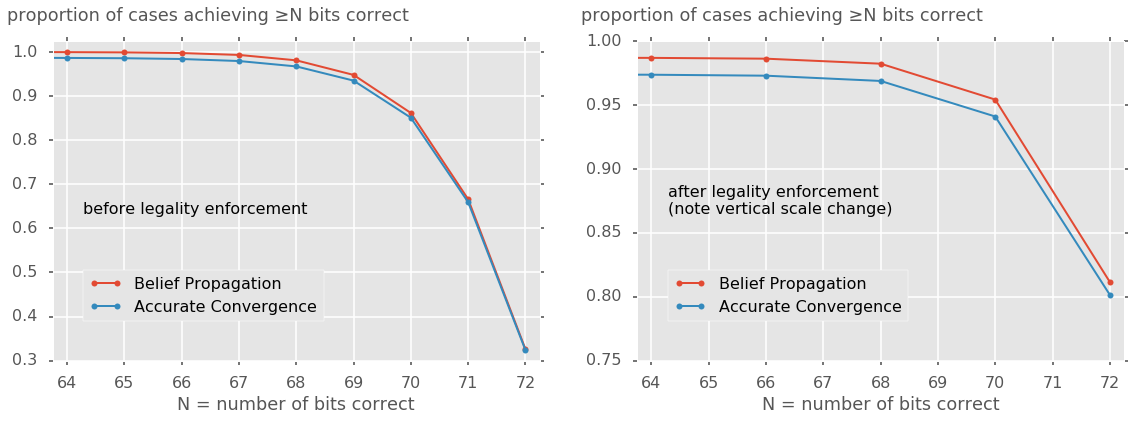

In [17]:
plt.style.use('ggplot')  # Next line doesn't work without this one first....
plt.style.use('seaborn-poster')
plt.figure(figsize=(16.0, 6.0))

full_name = {'acs': 'Accurate Convergence',
             'fgs': 'Belief Propagation'}

def plot_1(aln, alg, stride=1, y0=0.3, y1=1.025):
    plt.plot(aln.index.values[::stride], aln[::stride], '.-', lw=2.0, ms=12.0, label=full_name[alg])
    plt.gca().set_xlim(63.75, 72.25)
    plt.gca().set_ylim(y0, y1)
    plt.gca().set_xlabel('N = number of bits correct')
    plt.gca().set_ylabel('proportion of cases achieving \u2265N bits correct',
                         rotation=0, ha='left', va='bottom', y=1.05)

for alg in ['fgs', 'acs']:
    raw_name = '{}_raw'.format(alg)
    plt.subplot(1, 2, 1)
    aln = at_least_n_counts[raw_name]
    aln = aln / float(aln.loc[0])
    plot_1(aln, alg)
    
    ecc_name = '{}_ecc'.format(alg)
    plt.subplot(1, 2, 2)
    aln = at_least_n_counts[ecc_name]
    aln = aln / float(aln.loc[0])
    plot_1(aln, alg, 2, 0.75, 1.0)

for plt_idx, lbl in [(1, 'before legality enforcement'),
                     (2, 'after legality enforcement\n(note vertical scale change)')]:
    plt.subplot(1, 2, plt_idx)
    plt.legend(loc=(0.0625, 0.125))
    plt.text(0.0625, 0.45, lbl,
             fontsize=16.0, ha='left', va='bottom', transform=plt.gca().transAxes);

plt.gcf().subplots_adjust(bottom=0.16, left=0.05, right=0.98)
plt.savefig('fig-20160908-2.png', dpi=50)